In [1]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install stable_baselines3
!pip install numpy --upgrade 

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.3.0


In [2]:
from gym import Env
from gym.spaces import Discrete, Box
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt
import numpy as np
import math
import gym
import stable_baselines3.common.env_checker
import random
import statistics
from os import path
from gym import spaces
from floris.tools.visualization import visualize_cut_plane

In [3]:
class wind_farm(gym.Env):
    global a1,a2,p1,p2
    a1=[]
    a2=[]
    p1=[]
    p2=[]
    def __init__(self):
        # Actions we can take are Absolute Angle Representation (theta(0-360 deg))
        self.action_space = Box(low=np.array([0,0]),high=np.array([360,360]))
        # dataframe least and highest values
        self.observation_space = Box(low=np.array([0,1,1,0,-1,-0.5]), high=np.array([360,18,18,1,1.5,0.5]))
        # Set state space
        n=2
        self.state = np.array([random.randint(0,n-1),random.sample(range(1,18),2),random.sample(range(0,360),2)],dtype=object)

    
    def farm_power(self,wind_d,wind_s,s1,s2):
        
        
        fi = FlorisInterface("inputs/gch.yaml")
        
        fi.floris.solver

        # 2. Modify the inputs with a more complex wind turbine layout
        D = 126.0  # Design the layout based on turbine diameter
        x = [6 * D,0]
        y = [5 * D, 0]

        # Pass the new data to FlorisInterface
        fi.reinitialize(
            layout_x=x,
            layout_y=y,
            wind_directions=wind_d,
            wind_speeds=wind_s
        )

        yaw_angles_1 = np.zeros( (2, 1, 2) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and two turbines
        yaw_angles_1[0, :, 0] = s1+50         # yaw the first turbine s1+50 degrees
        yaw_angles_1[0, :, 1] = s2+50
        # 3. Calculate the velocities at each turbine for all atmospheric conditions
        a1.append(yaw_angles_1[0].reshape(2,))  
        fi.calculate_wake(yaw_angles=yaw_angles_1)

        # 4. Get the total farm power
        turbine_powers = fi.get_turbine_powers() / 1000.0  # Given in W, so convert to kW
        farm_power_baseline = np.sum(turbine_powers, 2)  # Sum over the third dimension
        
        # 5. Develop the yaw control settings
        yaw_angles_2 = np.zeros( (2, 1, 2) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and two turbines
        yaw_angles_2[0, :, 0] = s1         # yaw the first turbine s1 degrees
        yaw_angles_2[0, :, 1] = s2            # yaw the second turbine s2 degrees
        
        a2.append(yaw_angles_2[0].reshape(2,))  
        # 6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
        fi.calculate_wake(yaw_angles=yaw_angles_2)

        # 7. Get the total farm power
        turbine_powers = fi.get_turbine_powers() / 1000.0
        farm_power_yaw = np.sum(turbine_powers, 2)

        # 8. Compare farm power with and without wake steering
        print('farm_power_baseline : {}, farm_power_yaw : {}'.format(farm_power_baseline[0],farm_power_yaw[0]))
        p1.append(farm_power_baseline[0])
        p2.append(farm_power_yaw[0])
        if farm_power_baseline.all()>0:
            difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
        else:
            difference = 100 * (farm_power_yaw - farm_power_baseline)
        
        print('Predefined_yaw_angle list:',a1)
        print('Power generated list:',p1)
        x3 = a1
        y3 = p1
        plt.scatter(x3, y3, color ="green")
        plt.title('Scatter Plot of Power generated vs predefined_yaw_angle')
        plt.xlabel('yaw_angle')
        plt.ylabel('Power generated')
        plt.grid()
        plt.show()
        
        print('Changed_yaw_angle list:',a2)
        print('Power generated list:',p2)
        x4 = a2
        y4 = p2
        plt.scatter(x4, y4, color ="blue")
        plt.title('Scatter Plot of Power generated vs changed_yaw_angle')
        plt.xlabel('yaw_angle')
        plt.ylabel('Power generated')
        plt.grid()
        plt.show()
        
        power_list = [np.amax(farm_power_baseline[0]),np.amax(farm_power_yaw)]
        print('Power_list:',power_list)
        return power_list

    def step(self, action):
        global max_pow 
        max_pow=-1000
        speed = env.observation_space.sample()[1:3]
        # Apply action
        #Absolute angle representation formula
#         print(action)
#         print(action[0])
#         print(action[1])
        self.state1 = math.radians(action[0] - 1*math.radians(180))
        self.state2 = math.radians(action[1] - 2*math.radians(180))
        print('Predefined Yaw Angle 1:',self.state1+50)
        print('Predefined Yaw Angle 2:',self.state2+50)
        print('Changed Yaw Angle 1:',self.state1)
        print('Changed Yaw Angle 2:',self.state2)
        if self.state1 >= 0 and self.state2 >= 0: 
            r = env.farm_power(action,speed,self.state1,self.state2)
            if r[1]>=max_pow:
                #self.reward = env.farm_power(action,speed,self.state1,self.state2)
                self.reward = r[1]
                max_pow=r[1]
                self.baseline_power = r[0]
        #any angle negative,reward is negative
            else: 
                self.reward = -1 
                self.baseline_power = -1
        else:
            self.reward = -1
            self.baseline_power = -1
        # Check if optimization is done
        if self.time_length <= 0: 
            done = True
        else:
            done = False
        # Set placeholder for info
        info = {'power':self.baseline_power}
        
        # Return step information
        return self.observation_space.sample(), self.reward, done, info

    def render(self):
        # Implement viz
        pass
    
    #Assuming that the agent is coming back to original state
    def reset(self):
        self.time_length = 60
        return self.observation_space.sample()

In [4]:
env = wind_farm()
# stable_baselines3.common.env_checker.check_env(env , warn= True) 

C:\Users\manoh\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [5]:
from stable_baselines3.sac.policies import CnnPolicy, MlpPolicy, MultiInputPolicy
from stable_baselines3.sac.sac import SAC
from stable_baselines3 import A2C
import stable_baselines3.common.env_checker

__all__ = ["CnnPolicy", "MlpPolicy", "MultiInputPolicy", "SAC"]

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Predefined Yaw Angle 1: 51.029802271341154
Predefined Yaw Angle 2: 50.82221907329241
Changed Yaw Angle 1: 1.0298022713411523
Changed Yaw Angle 2: 0.8222190732924066
farm_power_baseline : [9581.06795795  239.75449143], farm_power_yaw : [10000.00493976   723.70917071]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907])]
Power generated list: [array([9581.06795795,  239.75449143])]


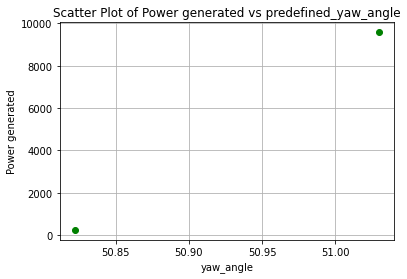

Changed_yaw_angle list: [array([1.02980227, 0.82221907])]
Power generated list: [array([10000.00493976,   723.70917071])]


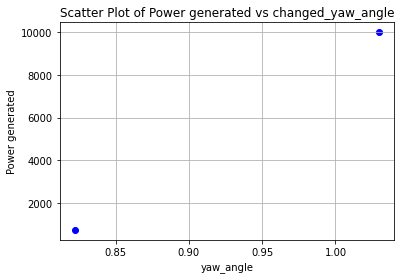

Power_list: [9581.06795795398, 10000.004939755185]
Predefined Yaw Angle 1: 51.26514548397632
Predefined Yaw Angle 2: 55.236944141793956
Changed Yaw Angle 1: 1.2651454839763183
Changed Yaw Angle 2: 5.236944141793959
farm_power_baseline : [672.79166341 265.73941401], farm_power_yaw : [1911.9135097   876.11199497]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401])]


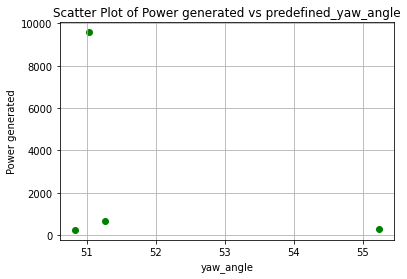

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497])]


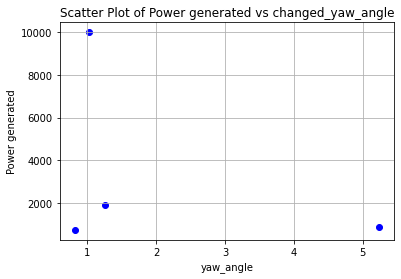

Power_list: [672.7916634080611, 1920.4350648137347]
Predefined Yaw Angle 1: 55.487631600771046
Predefined Yaw Angle 2: 50.7479865205417
Changed Yaw Angle 1: 5.487631600771046
Changed Yaw Angle 2: 0.7479865205417014
farm_power_baseline : [0. 0.], farm_power_yaw : [88.65944873  0.        ]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.])]


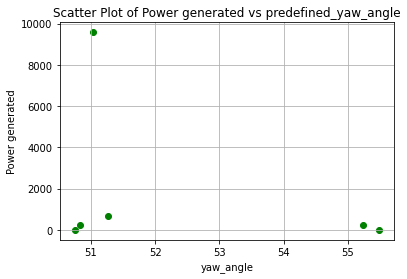

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ])]


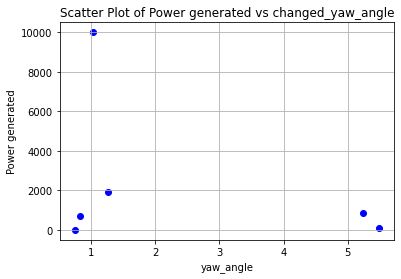

Power_list: [0.0, 88.65944873222624]
Predefined Yaw Angle 1: 53.97231158264359
Predefined Yaw Angle 2: 52.29633919040801
Changed Yaw Angle 1: 3.97231158264359
Changed Yaw Angle 2: 2.2963391904080095
farm_power_baseline : [ 41.25495094 154.64596119], farm_power_yaw : [182.04164206 406.39305467]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119])]


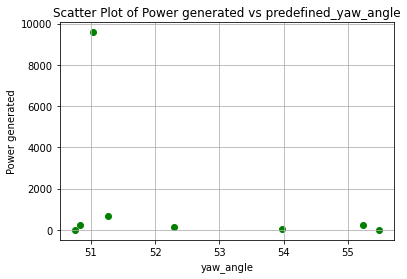

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467])]


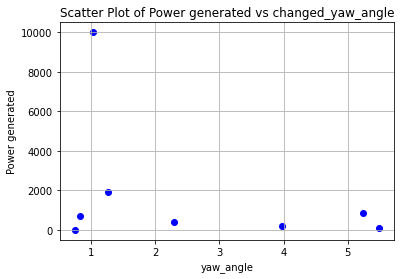

Power_list: [154.64596118649393, 623.6354906703815]
Predefined Yaw Angle 1: 51.43778649953736
Predefined Yaw Angle 2: 55.14673169039639
Changed Yaw Angle 1: 1.4377864995373588
Changed Yaw Angle 2: 5.146731690396397
farm_power_baseline : [ 429.78637946 2127.27899399], farm_power_yaw : [1298.40914955 5580.18112302]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399])]


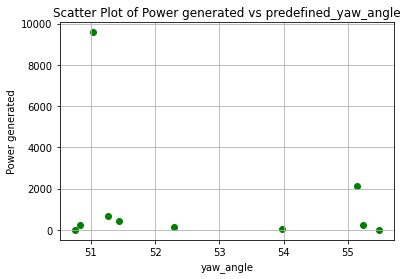

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302])]


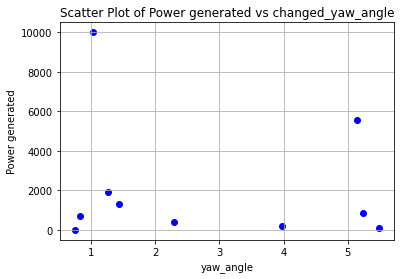

Power_list: [2127.2789939902127, 5602.177332654344]
Predefined Yaw Angle 1: 50.954740210489916
Predefined Yaw Angle 2: 55.21343748411627
Changed Yaw Angle 1: 0.9547402104899146
Changed Yaw Angle 2: 5.213437484116266
farm_power_baseline : [10000.00088854   301.07055235], farm_power_yaw : [10000.00070411   921.8373904 ]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235])]


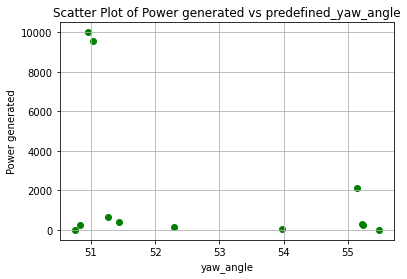

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ])]


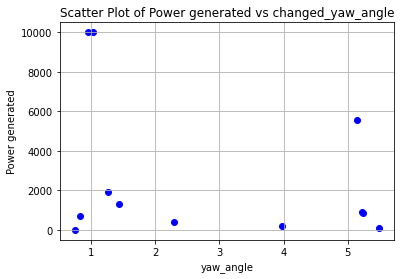

Power_list: [10000.000888540686, 10000.000704113612]
Predefined Yaw Angle 1: 54.748492012876056
Predefined Yaw Angle 2: 53.18380113836998
Changed Yaw Angle 1: 4.748492012876056
Changed Yaw Angle 2: 3.1838011383699816
farm_power_baseline : [1547.64233876 8468.19149588], farm_power_yaw : [ 4221.43895089 10000.00440842]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235]), array([1547.64233876, 8468.19149588])]


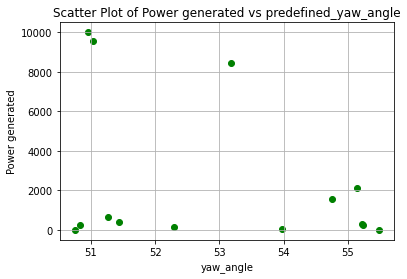

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842])]


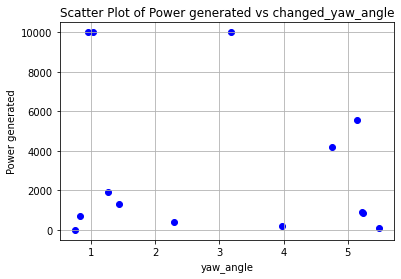

Power_list: [8468.191495876972, 10000.005231054654]
Predefined Yaw Angle 1: 53.993481582780845
Predefined Yaw Angle 2: 56.002787245939174
Changed Yaw Angle 1: 3.993481582780848
Changed Yaw Angle 2: 6.002787245939174
farm_power_baseline : [   0.         9999.99596151], farm_power_yaw : [1.94696738e+00 9.99999983e+03]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235]), array([1547.64233876, 8468.19149588]), array([   0.        , 9999.99596151])]


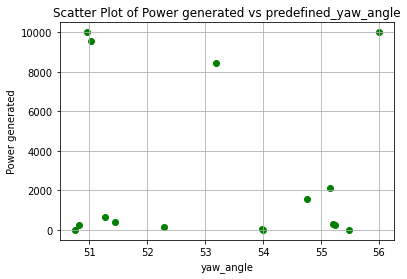

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03])]


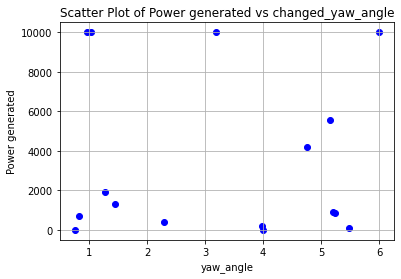

Power_list: [9999.995961513428, 10000.00665000324]
Predefined Yaw Angle 1: 52.17427757372826
Predefined Yaw Angle 2: 56.1148615867252
Changed Yaw Angle 1: 2.174277573728265
Changed Yaw Angle 2: 6.114861586725196
farm_power_baseline : [8709.4510026   101.68836747], farm_power_yaw : [10000.01068658   480.71248913]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235]), array([1547.64233876, 8468.19149588]), array([   0.        , 9999.99596151]), array([8709.4510026 ,  101.68836

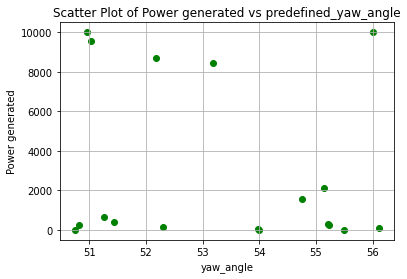

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913])]


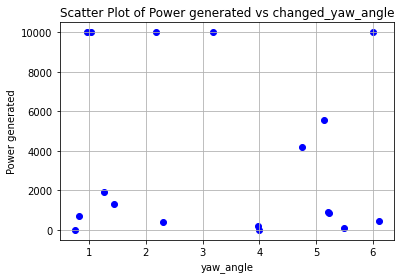

Power_list: [8709.451002597416, 10000.011759835545]
Predefined Yaw Angle 1: 50.08965011397564
Predefined Yaw Angle 2: 54.34409621684341
Changed Yaw Angle 1: 0.08965011397563964
Changed Yaw Angle 2: 4.34409621684341
farm_power_baseline : [6963.44366355 7553.30745953], farm_power_yaw : [9999.99874957 9999.99789862]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235]), array([1547.64233876, 8468.19149588]), array([   0.        , 9999.99596151

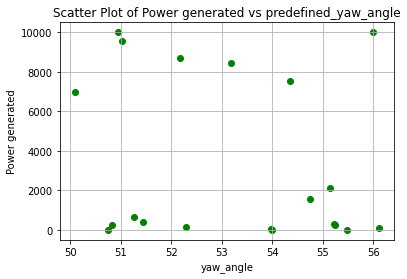

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862])]


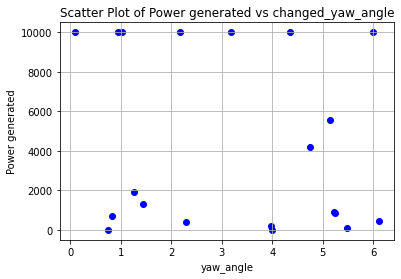

Power_list: [7553.307459525875, 9999.998749570575]
Predefined Yaw Angle 1: 55.08893561292968
Predefined Yaw Angle 2: 55.86502405327825
Changed Yaw Angle 1: 5.088935612929681
Changed Yaw Angle 2: 5.865024053278247
farm_power_baseline : [4436.54260693 5832.34629077], farm_power_yaw : [ 9999.99592829 10000.00211769]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235]), array([1547.64233876, 8468.19149588]), 

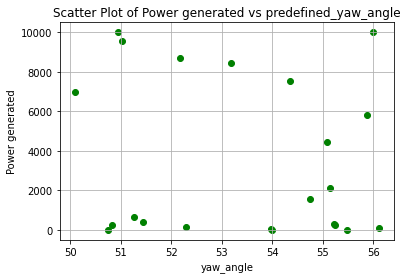

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]), array([ 9999.99592829, 10000.00211769])]


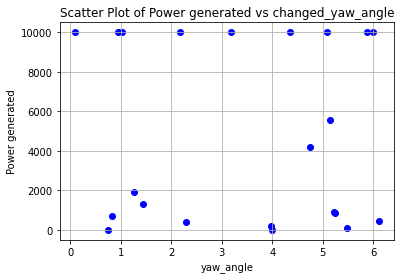

Power_list: [5832.346290769388, 10000.002117691434]
Predefined Yaw Angle 1: 50.39156606214471
Predefined Yaw Angle 2: 53.07834874763444
Changed Yaw Angle 1: 0.3915660621447113
Changed Yaw Angle 2: 3.078348747634441
farm_power_baseline : [ 191.29890582 7380.88821087], farm_power_yaw : [ 642.50369886 9999.99510938]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10000.00088854,   301.07055235]), arra

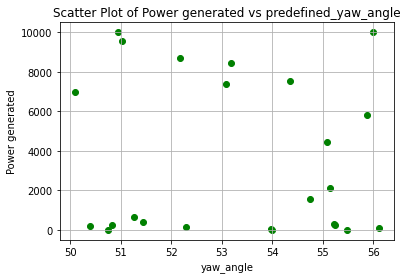

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]), array([ 9999.99592829, 10000.00211769]), array([ 642.50369886, 9999.99510938])]


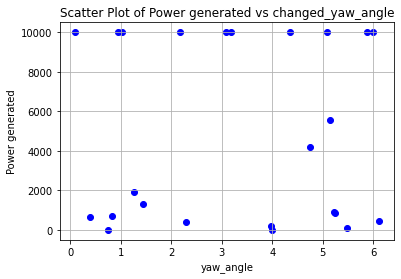

Power_list: [7380.888210866486, 9999.995109384628]
Predefined Yaw Angle 1: 55.996492442896844
Predefined Yaw Angle 2: 55.24040252278554
Changed Yaw Angle 1: 5.996492442896846
Changed Yaw Angle 2: 5.240402522785536
farm_power_baseline : [6553.63354716 8365.67345413], farm_power_yaw : [ 9999.99821335 10000.01496461]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.78637946, 2127.27899399]), array([10

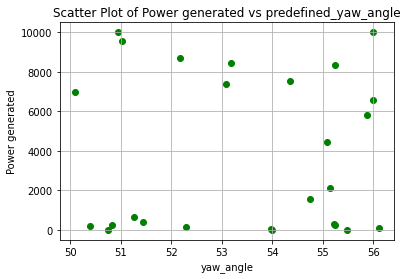

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]), array([ 9999.99592829, 10000.00211769]), array([ 642.50369886, 9999.99510938]), array([ 9999.99821335, 10000.01496461])]


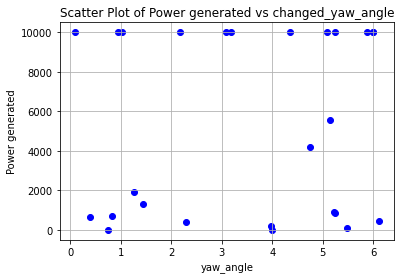

Power_list: [8365.673454130256, 10000.016595267625]
Predefined Yaw Angle 1: 50.37215254990441
Predefined Yaw Angle 2: 52.14535313661873
Changed Yaw Angle 1: 0.3721525499044152
Changed Yaw Angle 2: 2.14535313661873
farm_power_baseline : [9903.62139038  415.63992994], farm_power_yaw : [10000.01782845  1152.60453342]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495094, 154.64596119]), array([ 429.7

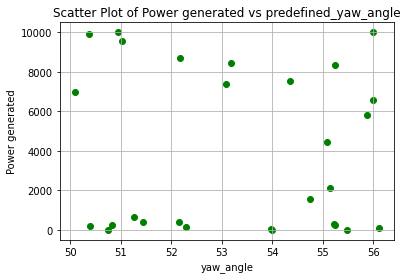

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]), array([ 9999.99592829, 10000.00211769]), array([ 642.50369886, 9999.99510938]), array([ 9999.998

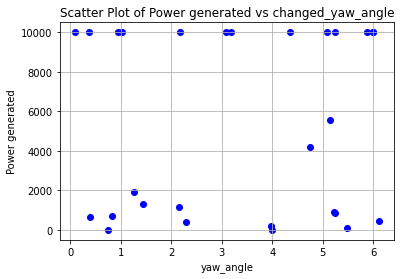

Power_list: [9903.621390382603, 10000.01782844521]
Predefined Yaw Angle 1: 52.083676700285714
Predefined Yaw Angle 2: 51.37487160480293
Changed Yaw Angle 1: 2.083676700285715
Changed Yaw Angle 2: 1.3748716048029248
farm_power_baseline : [1144.47967615 8195.02042011], farm_power_yaw : [ 2901.9737362  10000.00406264]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401]), array([0., 0.]), array([ 41.25495

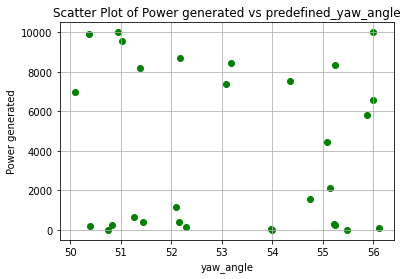

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]), array([ 9999.99592829, 10000.00211769]), array([ 642.50369886, 99

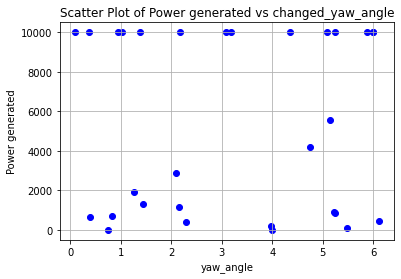

Power_list: [8195.020420109493, 10000.004148102777]
Predefined Yaw Angle 1: 53.95501861242127
Predefined Yaw Angle 2: 52.25334565040199
Changed Yaw Angle 1: 3.9550186124212696
Changed Yaw Angle 2: 2.253345650401988
farm_power_baseline : [2773.60589788 9999.99446313], farm_power_yaw : [ 5612.38917241 10000.00983219]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565])]
Power generated list: [array([9581.06795795,  239.75449143]), array([672.79166341, 265.73941401])

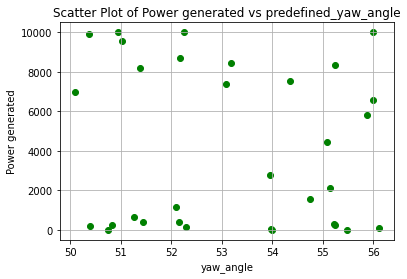

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]), array([ 9999.99592829, 10000.002

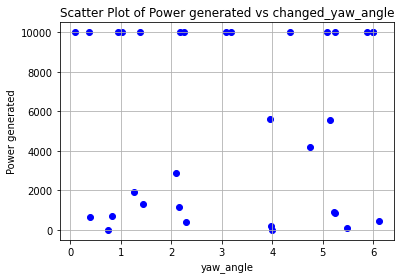

Power_list: [9999.994463130584, 10000.014016332974]
Predefined Yaw Angle 1: 53.13755785371203
Predefined Yaw Angle 2: 55.07880510363284
Changed Yaw Angle 1: 3.13755785371203
Changed Yaw Angle 2: 5.078805103632836
farm_power_baseline : [ 177.74554975 6224.46483519], farm_power_yaw : [  685.93361959 10000.00168835]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ])]
Power generated list: [array([9581.06795795,  239.75449143]), ar

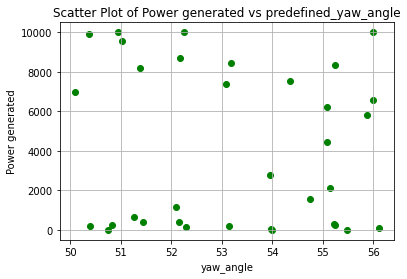

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array([9999.99874957, 9999.99789862]),

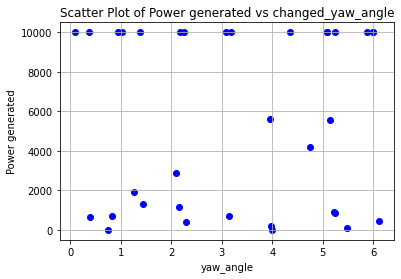

Power_list: [6224.464835190126, 10000.001688347915]
Predefined Yaw Angle 1: 51.38566617331758
Predefined Yaw Angle 2: 55.74567448902634
Changed Yaw Angle 1: 1.3856661733175817
Changed Yaw Angle 2: 5.745674489026346
farm_power_baseline : [   0.         7552.05096454], farm_power_yaw : [   16.51538862 10000.00318869]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449])]
Power generated list: [arra

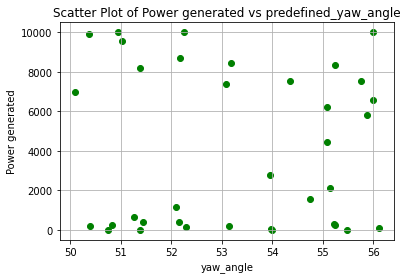

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.01068658,   480.71248913]), array

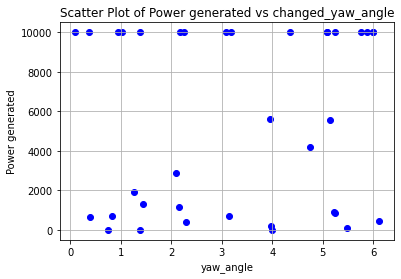

Power_list: [7552.05096454275, 10000.00366700208]
Predefined Yaw Angle 1: 52.83803905012965
Predefined Yaw Angle 2: 51.38147411377745
Changed Yaw Angle 1: 2.8380390501296526
Changed Yaw Angle 2: 1.3814741137774493
farm_power_baseline : [10000.00046724   119.0152619 ], farm_power_yaw : [10000.0008924    472.21467748]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.381

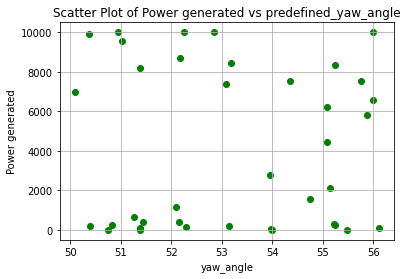

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00, 9.99999983e+03]), array([10000.

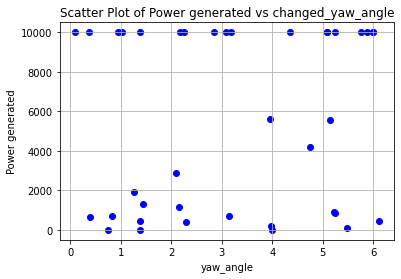

Power_list: [10000.000467235943, 10000.000892402575]
Predefined Yaw Angle 1: 54.229633664018095
Predefined Yaw Angle 2: 52.86728976913624
Changed Yaw Angle 1: 4.229633664018098
Changed Yaw Angle 2: 2.8672897691362444
farm_power_baseline : [138.64167723 399.35191273], farm_power_yaw : [ 555.56111887 1237.02778301]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.381474

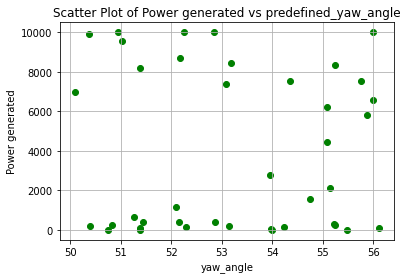

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.00440842]), array([1.94696738e+00

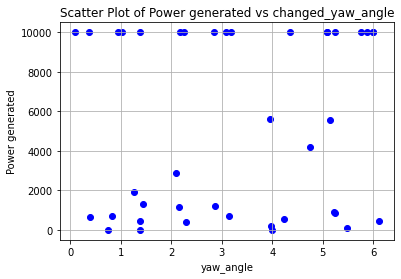

Power_list: [399.3519127318767, 1242.030001808989]
Predefined Yaw Angle 1: 54.86183987729535
Predefined Yaw Angle 2: 53.99787488880486
Changed Yaw Angle 1: 4.861839877295354
Changed Yaw Angle 2: 3.997874888804858
farm_power_baseline : [1354.50806341 3061.84057395], farm_power_yaw : [3806.4575533  8361.79508352]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411

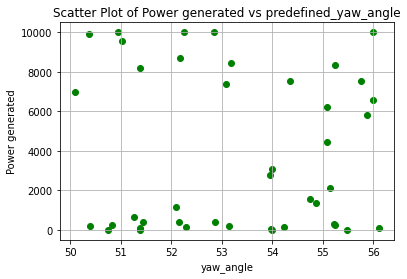

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 ]), array([ 4221.43895089, 10000.

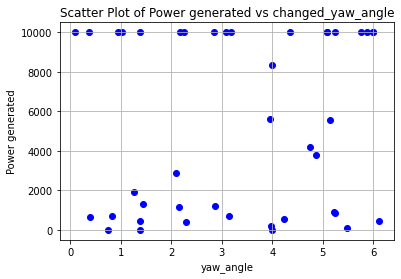

Power_list: [3061.8405739454956, 8361.795083516641]
Predefined Yaw Angle 1: 50.8273804568903
Predefined Yaw Angle 2: 54.43753775106269
Changed Yaw Angle 1: 0.8273804568903005
Changed Yaw Angle 2: 4.437537751062694
farm_power_baseline : [ 266.60082892 5256.5204426 ], farm_power_yaw : [ 610.67720052 9264.81947913]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814741

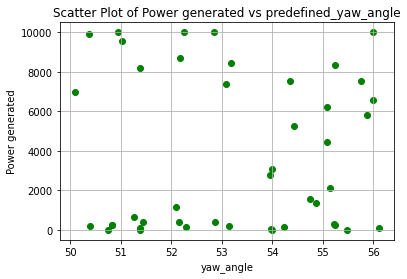

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), array([10000.00070411,   921.8373904 

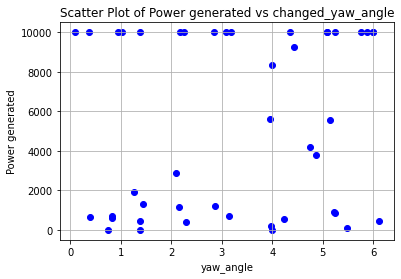

Power_list: [5256.520442599299, 10000.00327481295]
Predefined Yaw Angle 1: 51.83964339327654
Predefined Yaw Angle 2: 52.40911474150905
Changed Yaw Angle 1: 1.8396433932765386
Changed Yaw Angle 2: 2.40911474150905
farm_power_baseline : [   0.         1419.92582593], farm_power_yaw : [   0.         3616.74373267]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411

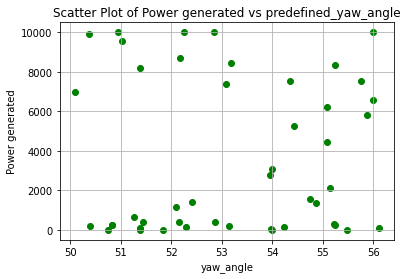

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([1298.40914955, 5580.18112302]), arra

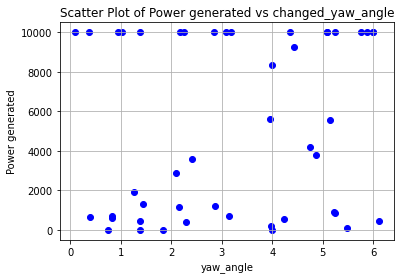

Power_list: [1419.9258259275412, 3621.6084048656758]
Predefined Yaw Angle 1: 51.244255914701846
Predefined Yaw Angle 2: 50.02724588870261
Changed Yaw Angle 1: 1.2442559147018457
Changed Yaw Angle 2: 0.02724588870260668
farm_power_baseline : [  0.         344.09019059], farm_power_yaw : [  0.         966.40594909]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.381474

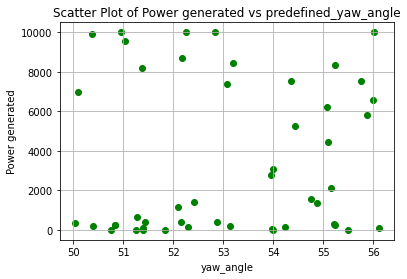

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.04164206, 406.39305467]), array([129

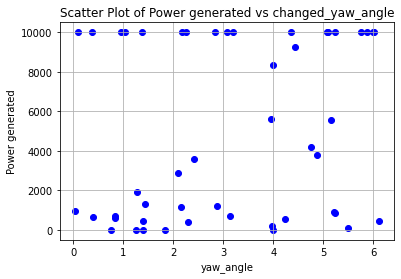

Power_list: [344.09019059085824, 966.6364046079113]
Predefined Yaw Angle 1: 53.001047944660094
Predefined Yaw Angle 2: 52.0484010234505
Changed Yaw Angle 1: 3.0010479446600944
Changed Yaw Angle 2: 2.048401023450505
farm_power_baseline : [634.57780299   0.        ], farm_power_yaw : [1756.9140503    0.       ]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411])

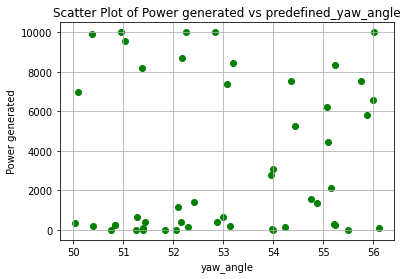

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.65944873,  0.        ]), array([182.041

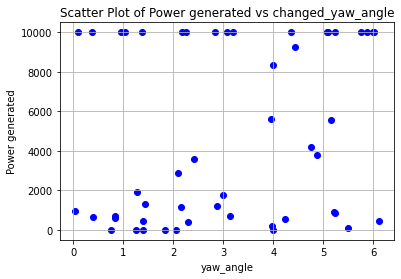

Power_list: [634.5778029886849, 1760.1951712752252]
Predefined Yaw Angle 1: 54.62081527652769
Predefined Yaw Angle 2: 55.77539536679163
Changed Yaw Angle 1: 4.620815276527695
Changed Yaw Angle 2: 5.77539536679163
farm_power_baseline : [2483.65442605  597.01692919], farm_power_yaw : [7044.08148713 1876.34999181]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411

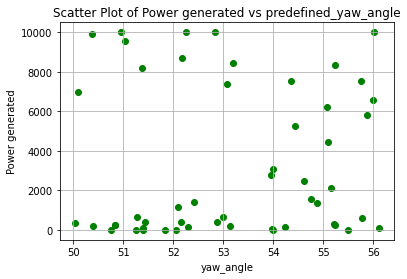

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 ,  876.11199497]), array([88.659448

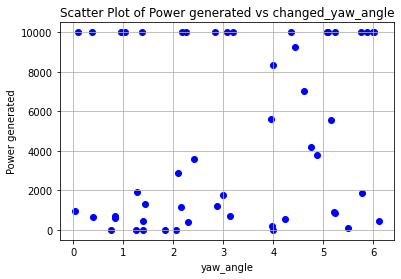

Power_list: [2483.654426050457, 7098.90208998034]
Predefined Yaw Angle 1: 51.5492953180659
Predefined Yaw Angle 2: 52.35150018080238
Changed Yaw Angle 1: 1.5492953180659033
Changed Yaw Angle 2: 2.3515001808023848
farm_power_baseline : [9901.33680062  166.7891229 ], farm_power_yaw : [10000.01431792   586.69225764]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.381474

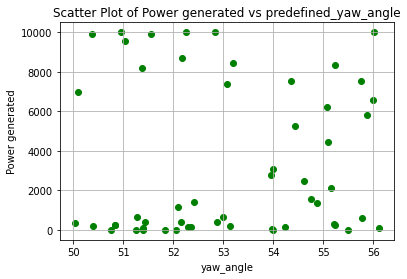

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018])]
Power generated list: [array([10000.00493976,   723.70917071]), array([1911.9135097 , 

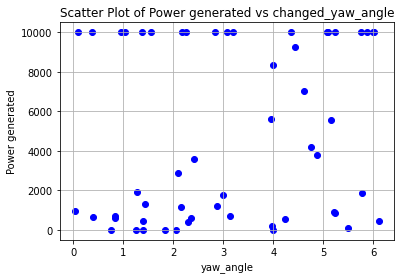

Power_list: [9901.336800617773, 10000.014317915793]
Predefined Yaw Angle 1: 51.96736939810506
Predefined Yaw Angle 2: 52.358216939387674
Changed Yaw Angle 1: 1.9673693981050657
Changed Yaw Angle 2: 2.3582169393876735
farm_power_baseline : [5236.96900164 9999.99650996], farm_power_yaw : [9999.99607831 9999.99644564]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814

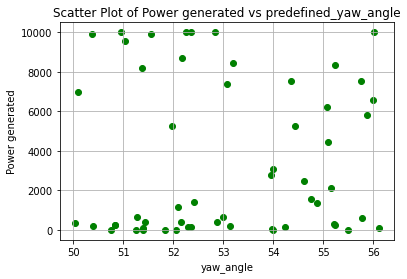

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694])]
Power generated list: [array([10000.00493976,   723.7

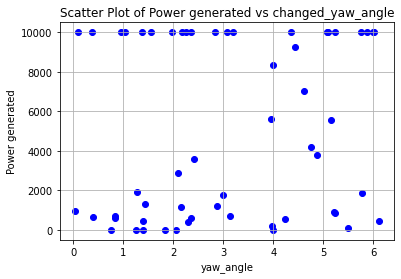

Power_list: [9999.996509960081, 9999.997034323844]
Predefined Yaw Angle 1: 55.35915591609566
Predefined Yaw Angle 2: 55.4314747436188
Changed Yaw Angle 1: 5.359155916095661
Changed Yaw Angle 2: 5.431474743618797
farm_power_baseline : [ 475.27445787 4210.60859163], farm_power_yaw : [1558.14104003 9999.99651259]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]

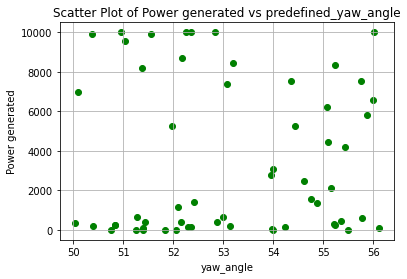

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474])]
Power generated list

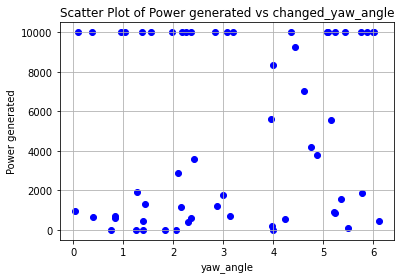

Power_list: [4210.608591627695, 9999.996512593343]
Predefined Yaw Angle 1: 50.2748608836972
Predefined Yaw Angle 2: 54.79439654344335
Changed Yaw Angle 1: 0.2748608836972044
Changed Yaw Angle 2: 4.79439654344335
farm_power_baseline : [ 108.35185483 8429.96978615], farm_power_yaw : [  458.13024419 10000.00239814]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814741

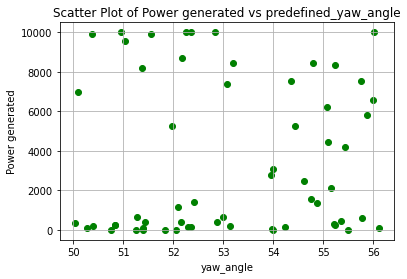

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

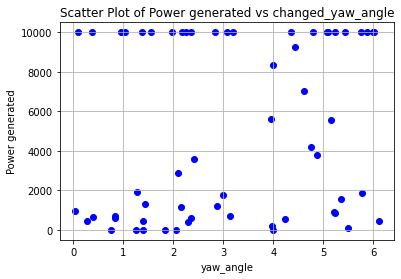

Power_list: [8429.969786150632, 10000.002398143484]
Predefined Yaw Angle 1: 50.49848765227462
Predefined Yaw Angle 2: 53.67450215133864
Changed Yaw Angle 1: 0.49848765227462133
Changed Yaw Angle 2: 3.6745021513386407
farm_power_baseline : [5038.23808325  329.97103138], farm_power_yaw : [9999.99612119  990.31244779]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814

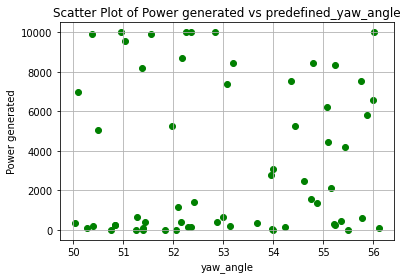

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

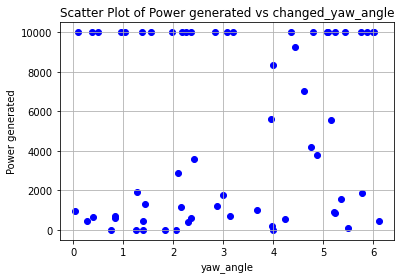

Power_list: [5038.238083251237, 9999.9961211937]
Predefined Yaw Angle 1: 53.59589293732074
Predefined Yaw Angle 2: 53.20410241535966
Changed Yaw Angle 1: 3.5958929373207384
Changed Yaw Angle 2: 3.204102415359656
farm_power_baseline : [ 977.86867846 1887.06295786], farm_power_yaw : [2692.3627732  4993.72094286]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]

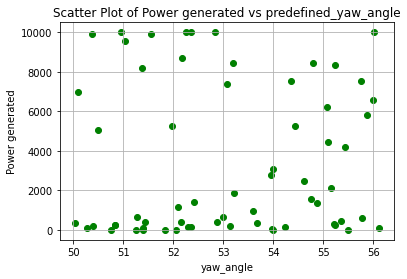

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

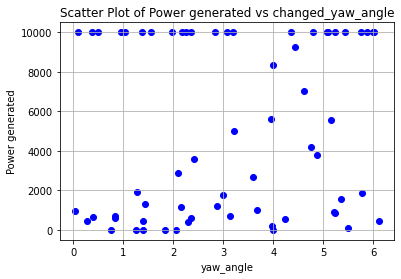

Power_list: [1887.0629578613868, 5010.93369869697]
Predefined Yaw Angle 1: 51.37814553955725
Predefined Yaw Angle 2: 51.711549095601015
Changed Yaw Angle 1: 1.3781455395572524
Changed Yaw Angle 2: 1.7115490956010146
farm_power_baseline : [9999.99948104 1448.53325927], farm_power_yaw : [10000.01022137  3597.0658921 ]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.381

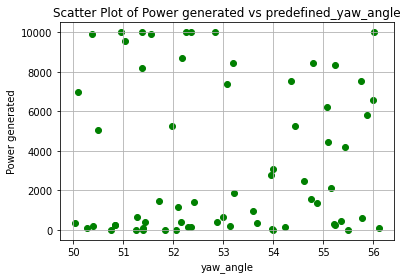

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

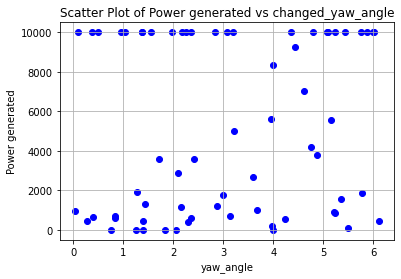

Power_list: [9999.999481037219, 10000.010221373137]
Predefined Yaw Angle 1: 51.01239478519196
Predefined Yaw Angle 2: 55.01348628420868
Changed Yaw Angle 1: 1.0123947851919584
Changed Yaw Angle 2: 5.013486284208681
farm_power_baseline : [0. 0.], farm_power_yaw : [17.70430369  0.        ]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]), array([54.22963366, 

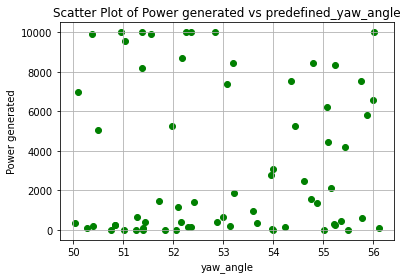

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

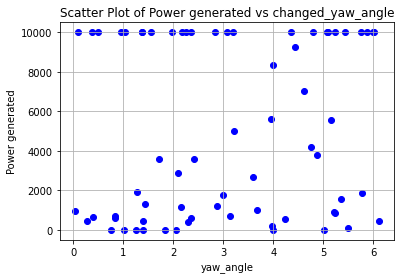

Power_list: [0.0, 18.196193004451946]
Predefined Yaw Angle 1: 52.68642342505868
Predefined Yaw Angle 2: 51.831419307846026
Changed Yaw Angle 1: 2.6864234250586785
Changed Yaw Angle 2: 1.8314193078460261
farm_power_baseline : [ 520.42472886 3783.71339054], farm_power_yaw : [1467.58770635 9392.64736432]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]), array(

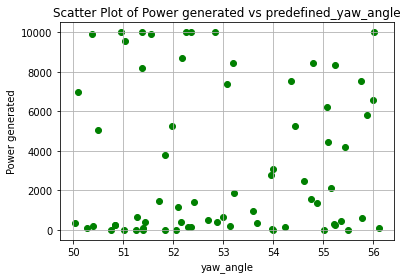

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

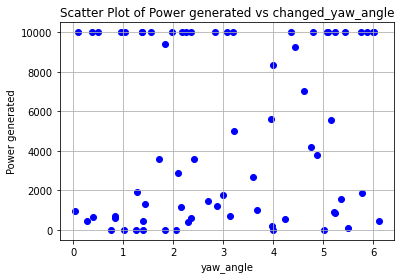

Power_list: [3783.7133905382625, 9406.182004400514]
Predefined Yaw Angle 1: 53.956337143476965
Predefined Yaw Angle 2: 53.94536800475286
Changed Yaw Angle 1: 3.9563371434769676
Changed Yaw Angle 2: 3.945368004752856
farm_power_baseline : [6341.59306631 6179.50010402], farm_power_yaw : [9999.99597851 9999.99727866]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147

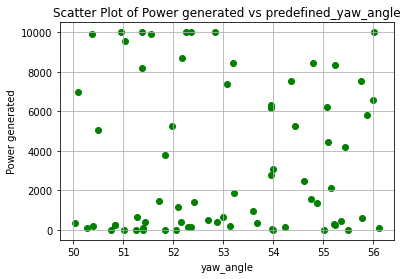

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

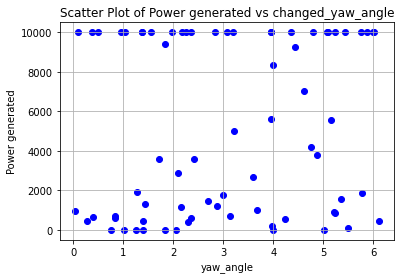

Power_list: [6341.593066306315, 9999.997278660565]
Predefined Yaw Angle 1: 53.444477848279845
Predefined Yaw Angle 2: 50.1640055606529
Changed Yaw Angle 1: 3.4444778482798473
Changed Yaw Angle 2: 0.16400556065289973
farm_power_baseline : [5819.12089909 6150.60417341], farm_power_yaw : [10000.0040311  10000.00554031]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.381

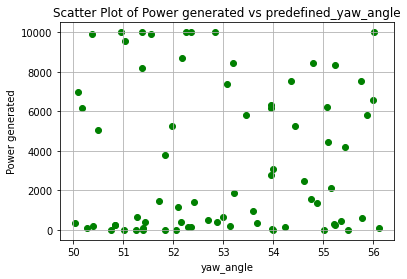

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

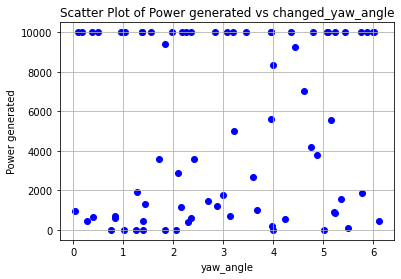

Power_list: [6150.604173406058, 10000.005540305046]
Predefined Yaw Angle 1: 51.41184850894248
Predefined Yaw Angle 2: 54.9842149480354
Changed Yaw Angle 1: 1.4118485089424777
Changed Yaw Angle 2: 4.984214948035402
farm_power_baseline : [926.76669185   0.        ], farm_power_yaw : [2544.38200164  101.78012832]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]

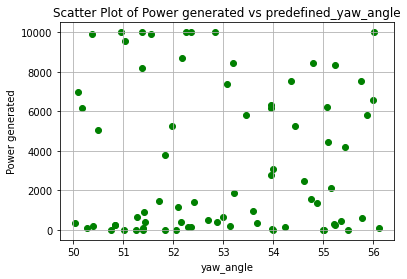

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

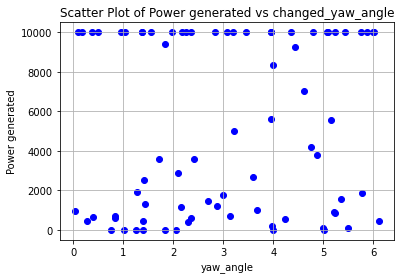

Power_list: [926.7666918532539, 2554.2217553543887]
Predefined Yaw Angle 1: 54.743351579339986
Predefined Yaw Angle 2: 52.563188730582276
Changed Yaw Angle 1: 4.743351579339985
Changed Yaw Angle 2: 2.5631887305822763
farm_power_baseline : [1956.660308    367.81245595], farm_power_yaw : [5227.87238925 1165.10523667]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814

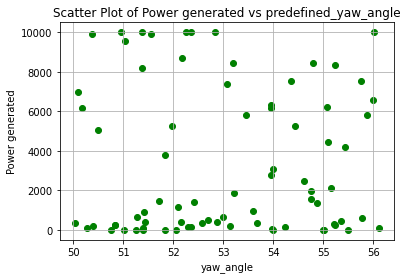

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

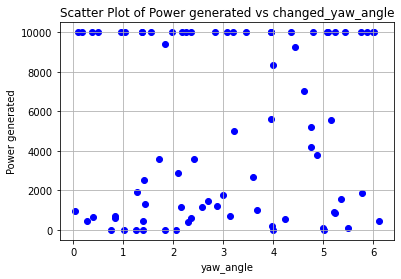

Power_list: [1956.6603079998622, 5249.77462734293]
Predefined Yaw Angle 1: 52.95856093789341
Predefined Yaw Angle 2: 52.38675111257122
Changed Yaw Angle 1: 2.9585609378934064
Changed Yaw Angle 2: 2.386751112571219
farm_power_baseline : [2002.68025153  226.10642368], farm_power_yaw : [5127.47329588  751.84051312]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814741

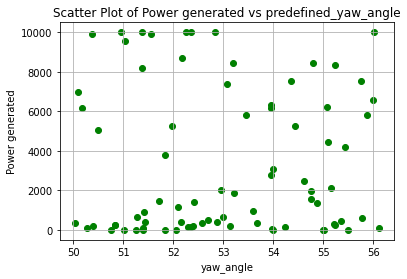

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

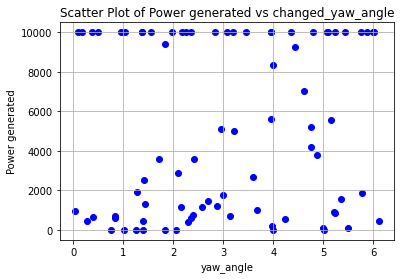

Power_list: [2002.680251530605, 5138.283110049586]
Predefined Yaw Angle 1: 50.79266328918295
Predefined Yaw Angle 2: 53.8871387864666
Changed Yaw Angle 1: 0.7926632891829458
Changed Yaw Angle 2: 3.8871387864666005
farm_power_baseline : [9788.24806522 1332.77517977], farm_power_yaw : [9999.99865349 2815.74492659]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814741

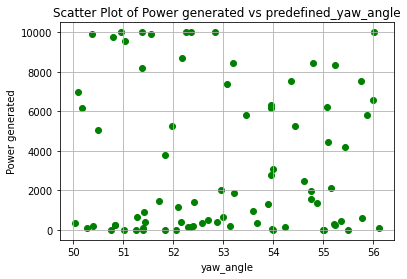

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

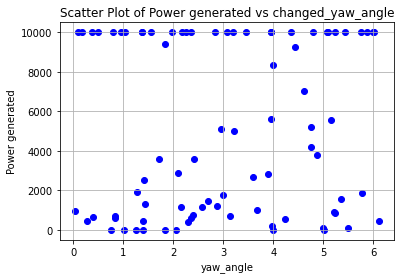

Power_list: [9788.248065220494, 9999.998653487544]
Predefined Yaw Angle 1: 50.50318433659406
Predefined Yaw Angle 2: 50.6402809623659
Changed Yaw Angle 1: 0.5031843365940578
Changed Yaw Angle 2: 0.6402809623658993
farm_power_baseline : [199.03579977 148.58881301], farm_power_yaw : [628.60377032 503.6483431 ]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]),

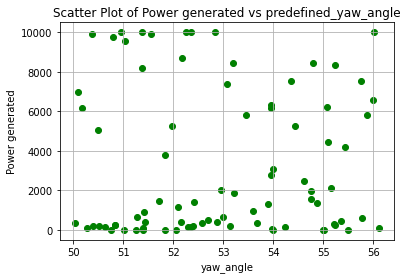

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

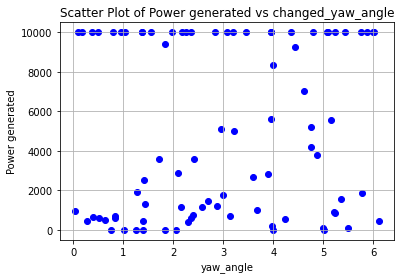

Power_list: [199.03579976600128, 628.6037703238841]
Predefined Yaw Angle 1: 52.94149699952483
Predefined Yaw Angle 2: 53.943000720859885
Changed Yaw Angle 1: 2.9414969995248326
Changed Yaw Angle 2: 3.9430007208598843
farm_power_baseline : [   0.         2542.72672558], farm_power_yaw : [   0.         6679.18146023]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.3814

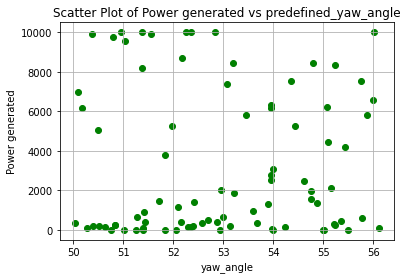

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

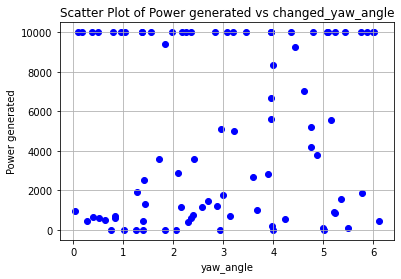

Power_list: [2542.726725584431, 6679.18146022675]
Predefined Yaw Angle 1: 49.98950038489845
Predefined Yaw Angle 2: 50.72707351544964
Changed Yaw Angle 1: -0.010499615101552123
Changed Yaw Angle 2: 0.7270735154496362
Predefined Yaw Angle 1: 50.957525211199865
Predefined Yaw Angle 2: 55.47683476856946
Changed Yaw Angle 1: 0.957525211199865
Changed Yaw Angle 2: 5.4768347685694625
farm_power_baseline : [  73.06924525 5824.74357758], farm_power_yaw : [  358.30301262 10000.00564812]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]),

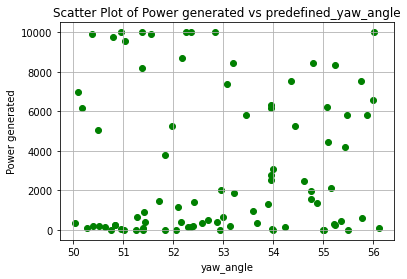

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

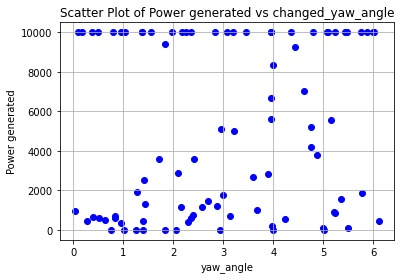

Power_list: [5824.743577575691, 10000.005648118513]
Predefined Yaw Angle 1: 51.022858145377796
Predefined Yaw Angle 2: 55.3058427823554
Changed Yaw Angle 1: 1.0228581453777978
Changed Yaw Angle 2: 5.305842782355399
farm_power_baseline : [197.91000242   5.18844015], farm_power_yaw : [698.34816542 172.63685187]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411])

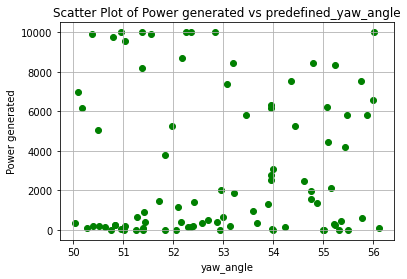

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

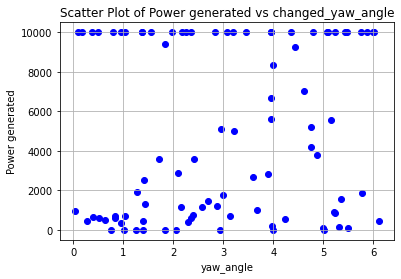

Power_list: [197.91000242350006, 703.4989604896415]
Predefined Yaw Angle 1: 51.79576275431141
Predefined Yaw Angle 2: 50.0086476782629
Changed Yaw Angle 1: 1.7957627543114119
Changed Yaw Angle 2: 0.008647678262903101
farm_power_baseline : [5088.36887853 5987.34499166], farm_power_yaw : [ 9999.99651152 10000.00347105]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38

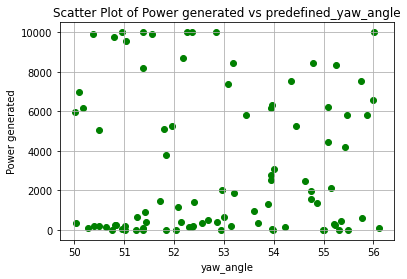

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

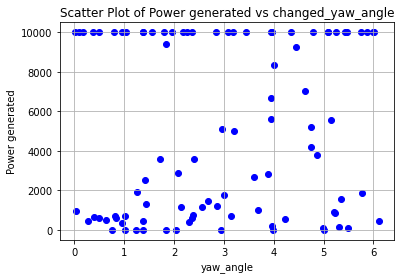

Power_list: [5987.344991659327, 10000.00351221952]
Predefined Yaw Angle 1: 50.921222930011695
Predefined Yaw Angle 2: 50.18784274991138
Changed Yaw Angle 1: 0.9212229300116951
Changed Yaw Angle 2: 0.18784274991138558
farm_power_baseline : [9999.99598353  567.983954  ], farm_power_yaw : [10000.01038618  1329.49915777]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38

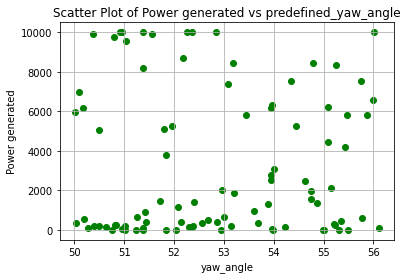

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

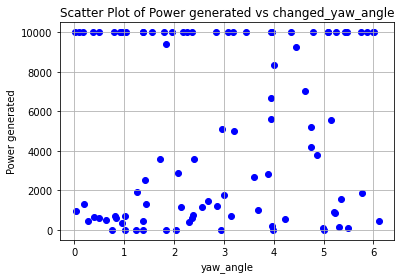

Power_list: [9999.995983526758, 10000.014574223622]
Predefined Yaw Angle 1: 52.55721031107745
Predefined Yaw Angle 2: 50.19315269365084
Changed Yaw Angle 1: 2.557210311077451
Changed Yaw Angle 2: 0.19315269365084006
farm_power_baseline : [   0.         7715.77830042], farm_power_yaw : [ 124.55833498 9999.99683831]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147

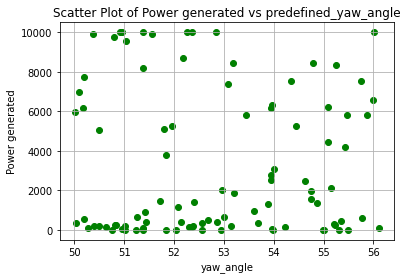

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

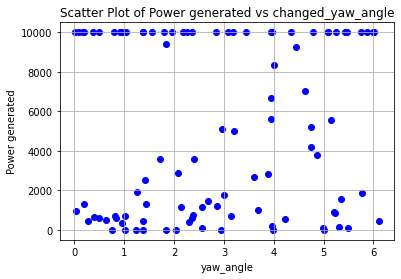

Power_list: [7715.778300421025, 9999.996926236054]
Predefined Yaw Angle 1: 55.4196698602811
Predefined Yaw Angle 2: 50.5998292764623
Changed Yaw Angle 1: 5.419669860281096
Changed Yaw Angle 2: 0.5998292764623042
farm_power_baseline : [2829.53309416  107.75283536], farm_power_yaw : [7278.65574712  467.88932476]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array([52.83803905, 51.38147411]

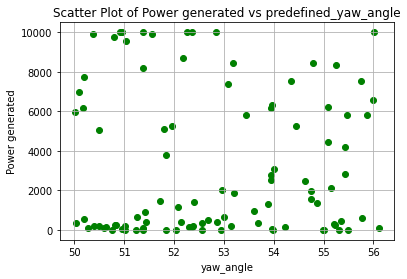

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

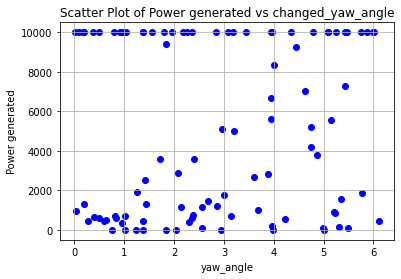

Power_list: [2829.5330941615803, 7278.655747122182]
7.062106 120.377304
Predefined Yaw Angle 1: 50.06842586857593
Predefined Yaw Angle 2: 51.99131802969742
Changed Yaw Angle 1: 0.06842586857592821
Changed Yaw Angle 2: 1.9913180296974191
farm_power_baseline : [3494.60206242 9999.99789947], farm_power_yaw : [ 8297.55505786 10000.01420793]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.08893561, 55.86502405]), array([50.39156606, 53.07834875]), array([55.99649244, 55.24040252]), array([50.37215255, 52.14535314]), array([52.0836767, 51.3748716]), array([53.95501861, 52.25334565]), array([53.13755785, 55.0788051 ]), array([51.38566617, 55.74567449]), array

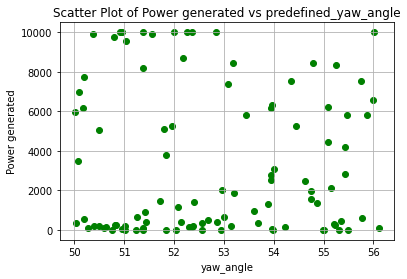

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

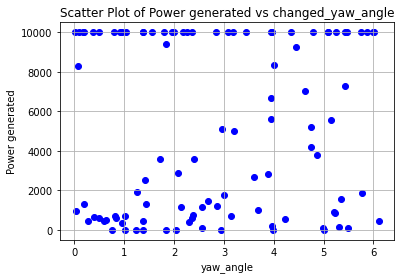

Power_list: [9999.997899470338, 10000.014207927441]
Wind_Direction:  133.5503387451172

Speed1:  4.523510932922363
 
Speed2:  6.583947658538818
 
Turbulance Intensity:  0.5862255692481995
 
Vear:  0.2486923187971115
 
Sheer:  -0.3012673258781433
 
Episode:  1 Score:  10000.014207927441
------------------------------------
9.083043 359.99997
Predefined Yaw Angle 1: 50.10369787260689
Predefined Yaw Angle 2: 56.17352250342415
Changed Yaw Angle 1: 0.1036978726068873
Changed Yaw Angle 2: 6.173522503424153
farm_power_baseline : [2549.6015932  9235.59680481], farm_power_yaw : [ 6601.5527424 10000.0064911]
Predefined_yaw_angle list: [array([51.02980227, 50.82221907]), array([51.26514548, 55.23694414]), array([55.4876316 , 50.74798652]), array([53.97231158, 52.29633919]), array([51.4377865 , 55.14673169]), array([50.95474021, 55.21343748]), array([54.74849201, 53.18380114]), array([53.99348158, 56.00278725]), array([52.17427757, 56.11486159]), array([50.08965011, 54.34409622]), array([55.088935

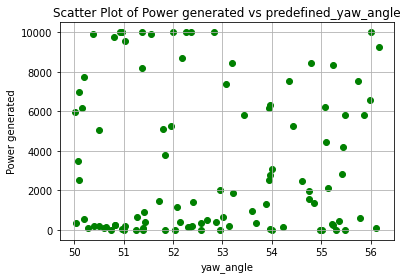

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

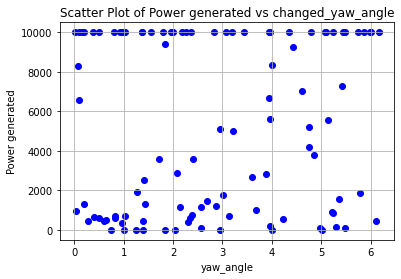

Power_list: [9235.596804808694, 10000.006491102093]
Wind_Direction:  334.4468078613281

Speed1:  16.419288635253906
 
Speed2:  16.412261962890625
 
Turbulance Intensity:  0.04201715439558029
 
Vear:  0.7121742963790894
 
Sheer:  -0.31840938329696655
 
Episode:  2 Score:  20000.020699029534
------------------------------------
0.0 29.924751
Predefined Yaw Angle 1: 49.94516886443839
Predefined Yaw Angle 2: 50.41262316658351
Changed Yaw Angle 1: -0.05483113556160755
Changed Yaw Angle 2: 0.4126231665835112
Wind_Direction:  338.25927734375

Speed1:  12.359307289123535
 
Speed2:  6.1987199783325195
 
Turbulance Intensity:  0.30213573575019836
 
Vear:  0.3935873210430145
 
Sheer:  -0.25255265831947327
 
Episode:  3 Score:  19999.020699029534
------------------------------------
0.003991127 159.17467
Predefined Yaw Angle 1: 49.945238522745655
Predefined Yaw Angle 2: 52.66845976004758
Changed Yaw Angle 1: -0.05476147725434516
Changed Yaw Angle 2: 2.6684597600475826
Wind_Direction:  68.005538940

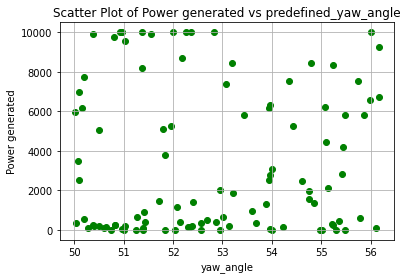

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

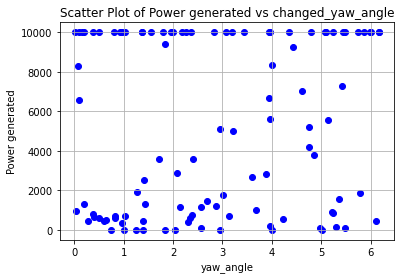

Power_list: [6720.611384092708, 9999.998174876826]
Wind_Direction:  259.56072998046875

Speed1:  3.8424856662750244
 
Speed2:  12.344671249389648
 
Turbulance Intensity:  0.18872466683387756
 
Vear:  0.7416025400161743
 
Sheer:  -0.35727906227111816
 
Episode:  5 Score:  29998.01887390636
------------------------------------
0.0 359.99982
Predefined Yaw Angle 1: 49.94516886443839
Predefined Yaw Angle 2: 56.17351984026306
Changed Yaw Angle 1: -0.05483113556160755
Changed Yaw Angle 2: 6.173519840263063
Wind_Direction:  76.71428680419922

Speed1:  9.151548385620117
 
Speed2:  5.308164596557617
 
Turbulance Intensity:  0.1350647211074829
 
Vear:  -0.9662345051765442
 
Sheer:  -0.45856326818466187
 
Episode:  6 Score:  29997.01887390636
------------------------------------
248.94545 210.54497
Predefined Yaw Angle 1: 54.29008662181457
Predefined Yaw Angle 2: 53.56504063789809
Changed Yaw Angle 1: 4.29008662181457
Changed Yaw Angle 2: 3.565040637898095
farm_power_baseline : [6889.77691485 223

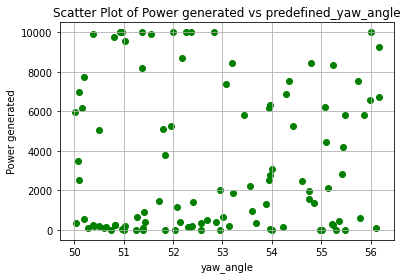

Changed_yaw_angle list: [array([1.02980227, 0.82221907]), array([1.26514548, 5.23694414]), array([5.4876316 , 0.74798652]), array([3.97231158, 2.29633919]), array([1.4377865 , 5.14673169]), array([0.95474021, 5.21343748]), array([4.74849201, 3.18380114]), array([3.99348158, 6.00278725]), array([2.17427757, 6.11486159]), array([0.08965011, 4.34409622]), array([5.08893561, 5.86502405]), array([0.39156606, 3.07834875]), array([5.99649244, 5.24040252]), array([0.37215255, 2.14535314]), array([2.0836767, 1.3748716]), array([3.95501861, 2.25334565]), array([3.13755785, 5.0788051 ]), array([1.38566617, 5.74567449]), array([2.83803905, 1.38147411]), array([4.22963366, 2.86728977]), array([4.86183988, 3.99787489]), array([0.82738046, 4.43753775]), array([1.83964339, 2.40911474]), array([1.24425591, 0.02724589]), array([3.00104794, 2.04840102]), array([4.62081528, 5.77539537]), array([1.54929532, 2.35150018]), array([1.9673694 , 2.35821694]), array([5.35915592, 5.43147474]), array([0.27486088, 4

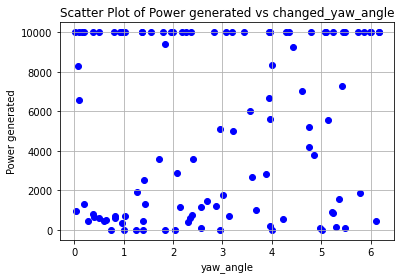

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Power_list: [6889.776914853171, 9999.996424540193]
Wind_Direction:  338.7994079589844

Speed1:  3.2656311988830566
 
Speed2:  12.212492942810059
 
Turbulance Intensity:  0.1331683248281479
 
Vear:  0.6088311076164246
 
Sheer:  -0.24024774134159088
 
Episode:  7 Score:  39997.01529844655
------------------------------------
0.0 360.0
Predefined Yaw Angle 1: 49.94516886443839
Predefined Yaw Angle 2: 56.17352303605637
Changed Yaw Angle 1: -0.05483113556160755
Changed Yaw Angle 2: 6.1735230360563715
Wind_Direction:  63.599910736083984

Speed1:  5.540951251983643
 
Speed2:  1.4007370471954346
 
Turbulance Intensity:  0.12866027653217316
 
Vear:  -0.022921081632375717
 
Sheer:  0.2380496710538864
 
Episode:  8 Score:  39996.01529844655
------------------------------------
0.00028967857 233.27904
Predefined Yaw Angle 1: 49.945173920283274
Predefined Yaw Angle 2: 53.961825008709
Changed Yaw Angle 1: -0.054826079716725595
Changed Yaw Angle 2: 3.9618250087090003
Wind_Direction:  66.3343429565429

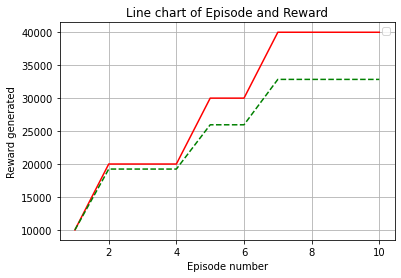

Mean of Predefined Yaw Power:  25097.71262019506
Mean of Changed Yaw Power:  25097.71262019506
StdDev of Predefined Yaw Power 11003.27123358097
StdDev of Changed Yaw Power 11003.27123358097


In [6]:


model = SAC(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50)
model.save("sac_wind_farm")

#del model remove to demonstrate saving and loading

#model = SAC.load("sac_wind_farm")

obs = env.reset()

episodes = 10
#done = False
ep_list = [i for i in range(1,11)]
score1 = 0
score2 = 0
rew = []
base_power = []
for episode in range(1, episodes+1):
    obs = env.reset() 
    #done = False
    #score = 0
    action, _states = model.predict(obs)
    print(action[0],action[1])
    obs, reward, done, info = env.step(action)
    #wind_direction - obs[0]
    #speed1 - obs[1]
    #speed2 - obs[2]
    #TI - obs[3]
    #vear - obs[4]
    #sheer - obs[5]
    print('Wind_Direction:  {}\n'.format(obs[0]))
    print('Speed1:  {}\n '.format(obs[1]))
    print('Speed2:  {}\n '.format(obs[2]))
    print('Turbulance Intensity:  {}\n '.format(obs[3]))
    print('Vear:  {}\n '.format(obs[4]))
    print('Sheer:  {}\n '.format(obs[5]))
    if done==True:
        break
    else:
        score1+=reward
        rew.append(score1)
        score2+=info.get('power')
        base_power.append(score2)
        
    print('Episode:  {} Score:  {}'.format(episode, score1))
    print("------------------------------------")

print('Predefined Yaw max power list:',base_power)
print('Changed Yaw max Power list:',rew)
plt.plot(ep_list, rew, color ="red")
plt.plot(ep_list,base_power,'--',color = "green")
plt.title('Line chart of Episode and Reward')
plt.xlabel('Episode number')
plt.ylabel('Reward generated')
plt.legend()
plt.grid()
plt.show()
print("Mean of Predefined Yaw Power: ",statistics.mean(base_power))
print("Mean of Changed Yaw Power: ",statistics.mean(base_power))
print("StdDev of Predefined Yaw Power",statistics.stdev(rew))
print("StdDev of Changed Yaw Power",statistics.stdev(rew))